In [1]:
import os
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# === CONFIG ===
ROOT_DIR = "/home/jithin/data/IMC/NewData/Tor/"  # Change this
OUTPUT_FILE = "jitter_delay_analysis-100.csv"
DELAY_SPIKE_THRESHOLD = 100  # in ms

def find_csv_files(root_dir):
    csv_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                csv_files.append(os.path.join(subdir, file))
    return csv_files

def analyze_file(file_path):
    try:
        df = pd.read_csv(file_path)
        if 'jitter_ms' not in df.columns or 'delay_ms' not in df.columns:
            return None

        mean_jitter = df['jitter_ms'].mean()
        delay_spikes = df[df['delay_ms'] > DELAY_SPIKE_THRESHOLD]['delay_ms']
        num_spikes = len(delay_spikes)
        spike_magnitudes = delay_spikes.tolist()

        return {
            "file": file_path,
            "mean_jitter_ms": round(mean_jitter, 3),
            "num_delay_spikes": num_spikes,
            "spike_magnitudes": ";".join(map(str, spike_magnitudes))
        }
    except Exception as e:
        return {"file": file_path, "mean_jitter_ms": None, "num_delay_spikes": None, "spike_magnitudes": f"ERROR: {e}"}

def main():
    csv_files = find_csv_files(ROOT_DIR)
    results = []

    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(analyze_file, f): f for f in csv_files}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Analyzing CSVs"):
            result = future.result()
            if result:
                results.append(result)

    # === Save to CSV ===
    df_result = pd.DataFrame(results)
    df_result.to_csv(OUTPUT_FILE, index=False)
    print(f"\nResults saved to {OUTPUT_FILE}")

if __name__ == "__main__":
    main()


Analyzing CSVs: 100%|███████████████████| 62796/62796 [00:52<00:00, 1202.36it/s]



Results saved to jitter_delay_analysis-100.csv


After Outlier Removal:
  Pearson Correlation: 0.683
  Spearman Correlation: 0.752
  Kendall Correlation : 0.580


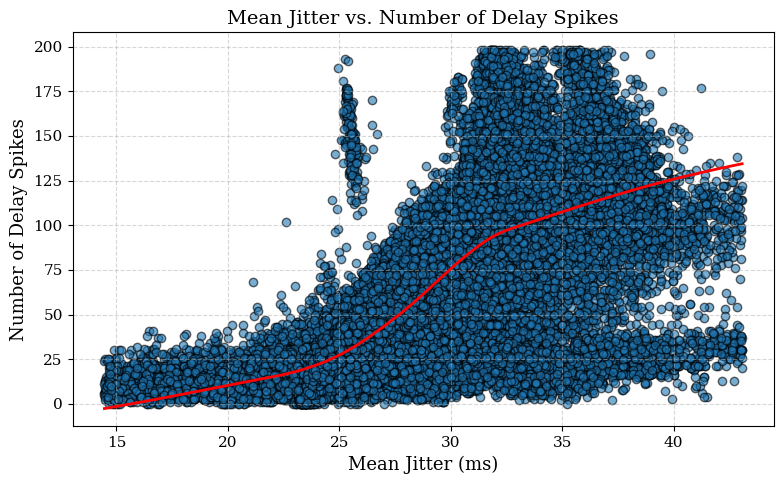

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from matplotlib import rcParams


# === CONFIGURE FOR ACADEMIC QUALITY PLOTS ===
rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "pdf.fonttype": 42,  # Editable fonts
})

# === Load and Clean ===
df = pd.read_csv("jitter_delay_analysis-100.csv")
df = df.dropna(subset=["mean_jitter_ms", "num_delay_spikes"])
df = df[df["num_delay_spikes"].apply(lambda x: str(x).isdigit())]
df["num_delay_spikes"] = df["num_delay_spikes"].astype(int)

# === IQR Outlier Removal ===
def remove_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Remove outliers from both columns
df = remove_outliers_iqr(df, "mean_jitter_ms")
df = remove_outliers_iqr(df, "num_delay_spikes")

# === Correlation ===
x = df["mean_jitter_ms"]
y = df["num_delay_spikes"]

pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)
kendall_corr, _ = kendalltau(x, y)

print(f"After Outlier Removal:")
print(f"  Pearson Correlation: {pearson_corr:.3f}")
print(f"  Spearman Correlation: {spearman_corr:.3f}")
print(f"  Kendall Correlation : {kendall_corr:.3f}")

# # === Scatter Plot ===
# plt.figure(figsize=(8, 5))
# plt.scatter(x, y, alpha=0.6, edgecolors='k')
# plt.xlabel("Mean Jitter (ms)")
# plt.ylabel("Number of Delay Spikes")
# plt.title("Mean Jitter vs. Number of Delay Spikes (Outliers Removed)")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

import seaborn as sns

# === Plot with Trend Line ===
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, lowess=True, scatter_kws={'alpha': 0.6, 'edgecolor': 'k'}, line_kws={"color": "red", "linewidth": 2})
plt.xlabel("Mean Jitter (ms)")
plt.ylabel("Number of Delay Spikes")
plt.title("Mean Jitter vs. Number of Delay Spikes")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("scatter_plot-delay_spikes_150ms.pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()



Filtered to 20408 samples with mean_jitter > 30 ms
Mean delay spikes: 101.95
Min spikes       : 0
Max spikes       : 198

Correlation (High Jitter Subset):
  Pearson Correlation : 0.028
  Spearman Correlation: 0.096
  Kendall Correlation : 0.055


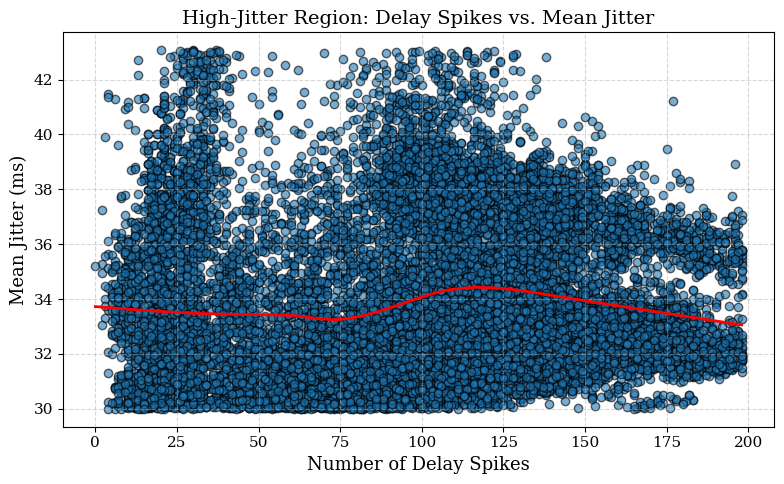

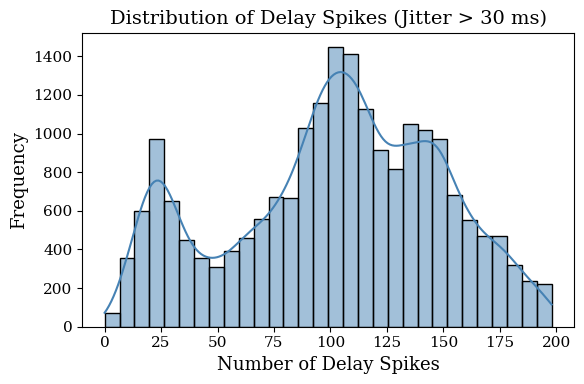

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau

# === Load and Clean ===
df = pd.read_csv("jitter_delay_analysis-100.csv")
df = df.dropna(subset=["mean_jitter_ms", "num_delay_spikes"])
df = df[df["num_delay_spikes"].apply(lambda x: str(x).isdigit())]
df["num_delay_spikes"] = df["num_delay_spikes"].astype(int)

# === IQR Outlier Removal ===
def remove_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return data[(data[column] >= lower) & (data[column] <= upper)]

df = remove_outliers_iqr(df, "mean_jitter_ms")
df = remove_outliers_iqr(df, "num_delay_spikes")

# === Focus Only on High Jitter Cases (> 30 ms) ===
df = df[df["mean_jitter_ms"] > 30]

# === Stats on Filtered Data ===
print(f"Filtered to {len(df)} samples with mean_jitter > 30 ms")
print(f"Mean delay spikes: {df['num_delay_spikes'].mean():.2f}")
print(f"Min spikes       : {df['num_delay_spikes'].min()}")
print(f"Max spikes       : {df['num_delay_spikes'].max()}")

# === Correlation ===
x = df["num_delay_spikes"]
y = df["mean_jitter_ms"]

pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)
kendall_corr, _ = kendalltau(x, y)

print("\nCorrelation (High Jitter Subset):")
print(f"  Pearson Correlation : {pearson_corr:.3f}")
print(f"  Spearman Correlation: {spearman_corr:.3f}")
print(f"  Kendall Correlation : {kendall_corr:.3f}")

# === Scatter Plot with LOWESS ===
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, lowess=True, scatter_kws={'alpha': 0.6, 'edgecolor': 'k'}, line_kws={"color": "red", "linewidth": 2})
plt.xlabel("Number of Delay Spikes")
plt.ylabel("Mean Jitter (ms)")
plt.title("High-Jitter Region: Delay Spikes vs. Mean Jitter")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Histogram of Delay Spikes in High-Jitter Region ===
plt.figure(figsize=(6, 4))
sns.histplot(df["num_delay_spikes"], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Delay Spikes (Jitter > 30 ms)")
plt.xlabel("Number of Delay Spikes")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
